In [1]:
import pandas as pd
import numpy as np
import itertools
import time
import random
import warnings
warnings.filterwarnings('ignore')
import math
import sys
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/amzn.us.txt')

In [3]:
data = df['Close'].as_matrix()[-180:-60]
test = df['Close'].as_matrix()[-60:]

In [4]:
X = df[-180:-60]
X.reset_index(drop=True, inplace=True)

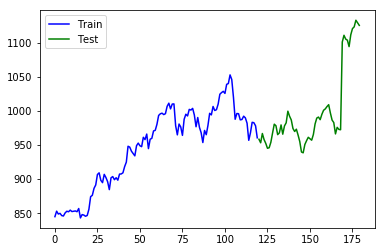

In [5]:
plt.plot(data, c='b', label='Train')
plt.plot(len(data)+np.array(range(len(test))), test, c='g', label='Test')
plt.legend()

plt.show()

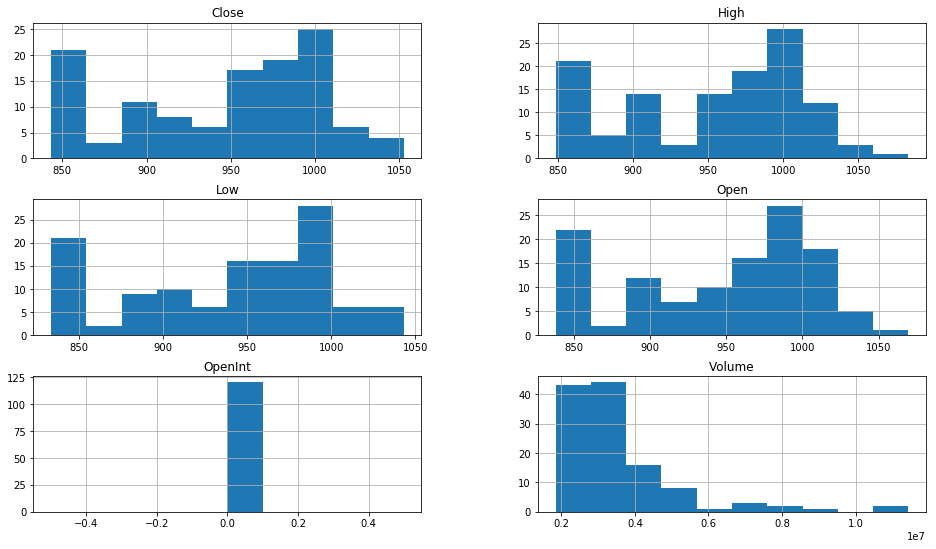

In [6]:
X.hist(figsize=(16,9))

plt.show()

In [7]:
def ts_diagnostics(y, lags=None, title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # weekly moving averages (5 day week -> 2week window)
    roll_mean = y.rolling(window=10).mean()
    roll_std = y.rolling(window=10).std()

    plt.figure(figsize=(16, 10))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))

    # time series plot
    y.plot(ax=ts_ax)
    roll_mean.plot(ax=ts_ax, color='crimson', label='rolling-mean');
    roll_std.plot(ax=ts_ax, color='darkslateblue', label='rolling-std');
    ts_ax.legend(loc='best')
    ts_ax.set_title(title, fontsize=24);

    # acf and pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')

    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.show()

    # perform Augmented Dickey Fuller test
    print('Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

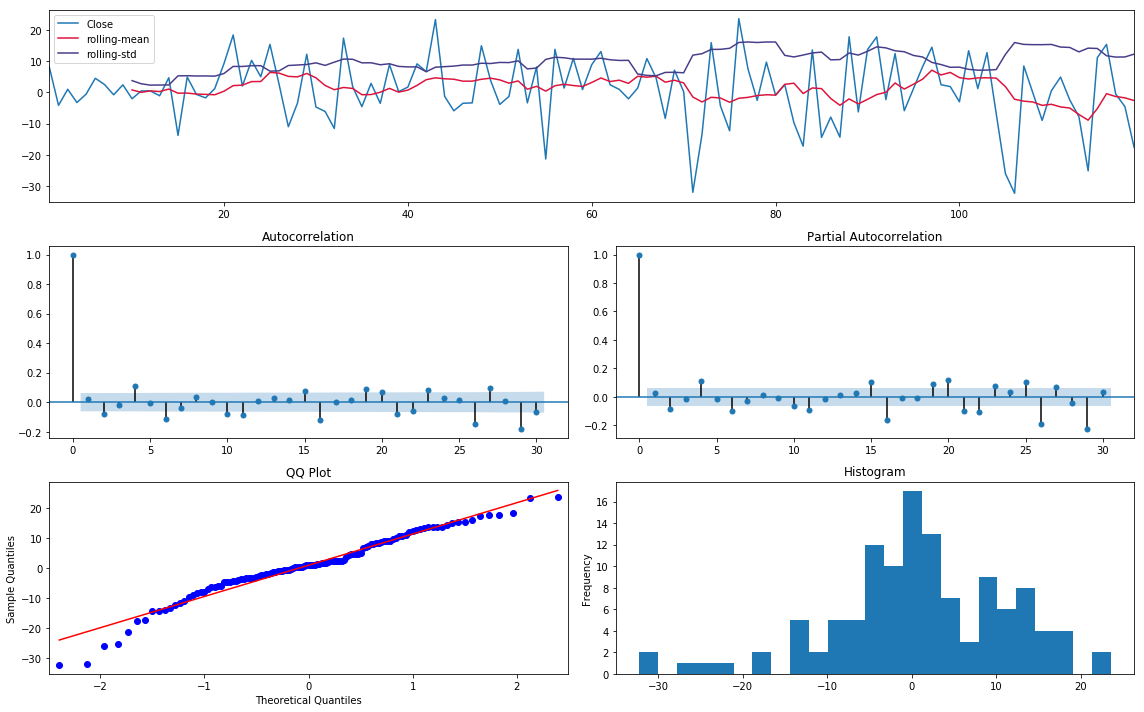

Dickey-Fuller test:
test statistic         -1.038685e+01
p-value                 2.069282e-18
# of lags               0.000000e+00
# of observations       1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


In [8]:
ts_diagnostics(X['Close'].diff().dropna(), lags=30)

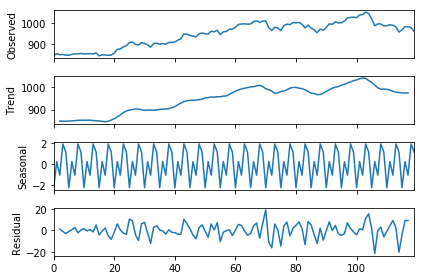

In [9]:
res = seasonal_decompose(X['Close'], model='add', freq=5) 
res.plot()

plt.show()

In [12]:
%%time
### grid search sarima params
model_choice = {}
p = q = range(0, 5)
d = [1]
season = 5
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(i, j, k, season) for i, j, k in pdq]
for order, season in itertools.product(pdq, seasonal_pdq):
    try:
        model = sm.tsa.statespace.SARIMAX(data,
                  order=order,
                  seasonal_order=season).fit(disp=0, method='nm')
    except:
        continue
    model_choice[(order, season)] = mse(data[-14:], model.fittedvalues[-14:])
order, season = min(model_choice, key=model_choice.get)

Wall time: 2min 42s


In [14]:
order, season = ((4, 1, 1), (4, 1, 4, 5))
order, season

((4, 1, 1), (4, 1, 4, 5))

In [15]:
%%time
clf_sar = sm.tsa.statespace.SARIMAX(data, 
                                    trend='n',
                                    order=order,
                                    seasonal_order=season
                                ).fit(disp=0, method='lbfgs')

Wall time: 3.62 s


In [16]:
clf_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  120
Model:             SARIMAX(4, 1, 1)x(4, 1, 4, 5)   Log Likelihood                -430.437
Date:                           Tue, 20 Aug 2019   AIC                            888.875
Time:                                   17:50:45   BIC                            927.181
Sample:                                        0   HQIC                           904.421
                                           - 120                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5000      0.875      0.571      0.568      -1.216       2.216
ar.L2         -0.1056      0.140     -0.753      0.451      -0.380       0.169
ar.L3          0.0226      0.136      0.167      0.868      -0.243       0.288
ar.L4          0.1694      0.134      1.269      0.204      -0.092       0.431
ma.L1         -0.4445      0.868     -0.512      0.609      -2.146       1.257
ar.S.L5       -1.3961      0.707     -1.976      0.048      -2.781      -0.011
ar.S.L10      -1.5526      0.520     -2.986      0.003      -2.572      -0.534
ar.S.L15      -1.1135      0.573     -1.943      0.052      -2.237       0.010
ar.S.L20      -0.2276      0.191     -1.191      0.234      -0.602       0.147
ma.S.L5        0.2802      0.808      0.347      0.729      -1.304       1.864
ma.S.L10       0.0925      1.524      0.061      0.952      -2.895       3.080
ma.S.L15      -0.4770      1.134     -0.421      0.674      -2.700       1.746
ma.S.L20      -0.8179      1.829     -0.447      0.655      -4.402       2.767
sigma2        92.4403    152.479      0.606      0.544    -206.413     391.294
===================================================================================
Ljung-Box (Q):                       21.13   Jarque-Bera (JB):                14.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NormaltestResult(statistic=array([10.20549966]), pvalue=array([0.00608]))


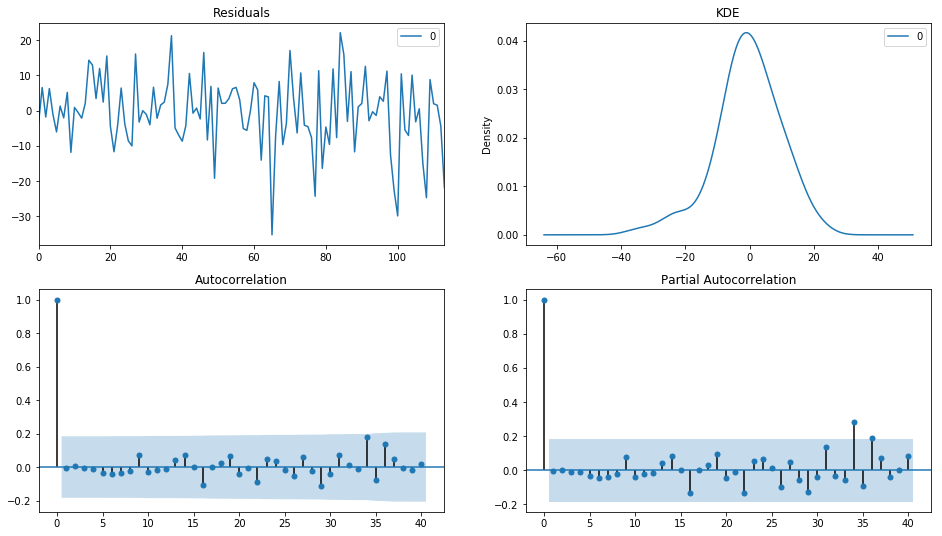

,0
count,114.000000
mean,-0.547623
std,10.235091
min,-35.274785
25%,-5.382693
50%,-0.190891
75%,6.344961
max,22.100192


In [19]:
resid = pd.DataFrame(clf_sar.resid[6:])
print(normaltest(resid))

plt.figure(figsize=(16, 9))
layout = (2, 2)
res_ax = plt.subplot2grid(layout, (0, 0))
kde_ax = plt.subplot2grid(layout, (0, 1))
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

resid.plot(ax=res_ax, title='Residuals')
resid.plot(ax=kde_ax, kind='kde', title='KDE')
plot_acf(resid, lags=40, ax=acf_ax)
plot_pacf(resid, lags=40, ax=pacf_ax)

plt.show()

resid.describe()

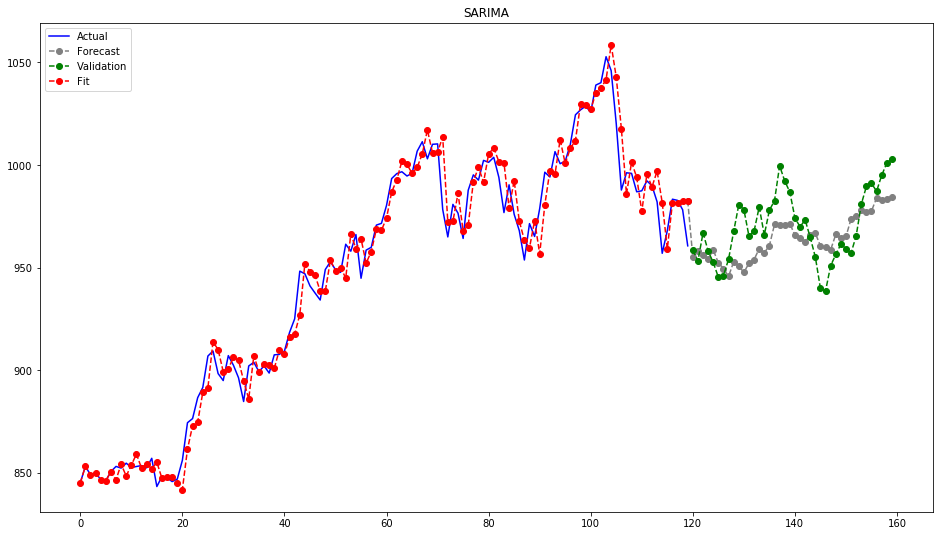

In [20]:
pred_period = 40
x = [i for i in range(len(data) -1, len(data) + pred_period)]
fcast = [clf_sar.fittedvalues[-1]]
for i in clf_sar.forecast(pred_period):
    fcast.append(i)

plt.figure(figsize=(16,9))
plt.plot(X['Close'], 'blue', label = 'Actual')
fit_y = [data[i] if i<7 else clf_sar.fittedvalues[i] 
         for i in range(0, len(data))]
plt.plot(x, fcast, 'o--', c='grey', label ='Forecast')
plt.plot(x[1:], test[:pred_period], 'o--', c='green', label ='Validation')
plt.plot(fit_y, 'o--', color='red', label = 'Fit')
plt.legend(loc=2)
plt.title('SARIMA')

plt.show()

In [23]:
##Keras
def split_sequence(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
        end = i + n_steps
        if end > len(seq)-1:
            break
        seq_x, seq_y = seq[i:end], seq[end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
seq = X['Close'].as_matrix()
n_steps = 5
X_train, y_train = split_sequence(seq, n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [27]:
#define model (Vanilla LSTM)
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
model.fit(X_train, y_train, epochs=600, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


MSE =  770.3651106138431


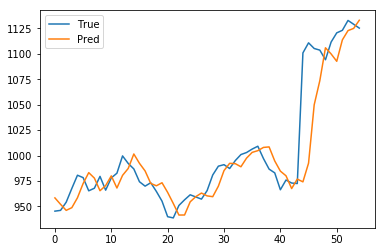

In [29]:
#prediction (Vanilla LSTM)
X_test, y_test = split_sequence(test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
yhat = model.predict(X_test, verbose=0)
print('MSE = ', mse(y_test, yhat))

plt.plot(y_test, label='True')
plt.plot(yhat, label='Pred')
plt.legend()

plt.show()

In [30]:
#define model (Stacked LSTM)
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(n_steps, 1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
model.fit(X_train, y_train, epochs=600, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 64)             16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None


MSE =  698.5253252886392


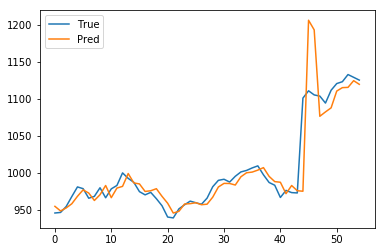

In [31]:
#prediction (Stacked LSTM)
X_test, y_test = split_sequence(test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
yhat = model.predict(X_test, verbose=0)
print('MSE = ', mse(y_test, yhat))

plt.plot(y_test, label='True')
plt.plot(yhat, label='Pred')
plt.legend()

plt.show()

In [ ]:
###ExpSmoothing

In [32]:
%%time
data = X['Close'].as_matrix()
alpha = np.linspace(0.0, 0.9, 12)
beta  = np.linspace(0.0, 0.9, 12)
gamma = np.linspace(0.0, 0.9, 12)
seasons = [7]
params = {}
mse_range = -15
for i, j, k in itertools.product(alpha, beta, gamma):
    for s in seasons:
        try:
            fit1 = ExponentialSmoothing(data,seasonal_periods=s,
                                        damped = True, trend='add',
                                        seasonal='add').fit(
                                        smoothing_level=i, smoothing_slope=j,
                                        smoothing_seasonal=k, remove_bias=True)
        except:
            continue
        params[(i, j, k, s)] = mse(data[mse_range:-1],
                                    fit1.fittedvalues[mse_range+1:])

if not params:
    s = 5; alpha = 0.1; beta = 0.1; gamma = 0.4
else:
    alpha, beta, gamma, s = min(params, key=params.get)

Wall time: 11 s


In [33]:
%%time
clf = ExponentialSmoothing(data, damped = True,
                           seasonal_periods=s, trend='add',
                           seasonal='add').fit(
                           smoothing_level=alpha, smoothing_slope=beta,
                           smoothing_seasonal=gamma, remove_bias=True)

Wall time: 24.9 ms


In [34]:
clf.params

{'damping_slope': 0.41591154529294455,
 'initial_level': 922.3488315962045,
 'initial_seasons': array([ -98.55666673, -103.40486063, -104.77626348, -103.12347053,
        -102.20936735, -101.6239858 ,  -99.91282892]),
 'initial_slope': 52.6464306578395,
 'lamda': None,
 'remove_bias': True,
 'smoothing_level': 0.8181818181818181,
 'smoothing_seasonal': 0.0,
 'smoothing_slope': 0.32727272727272727,
 'use_boxcox': False}

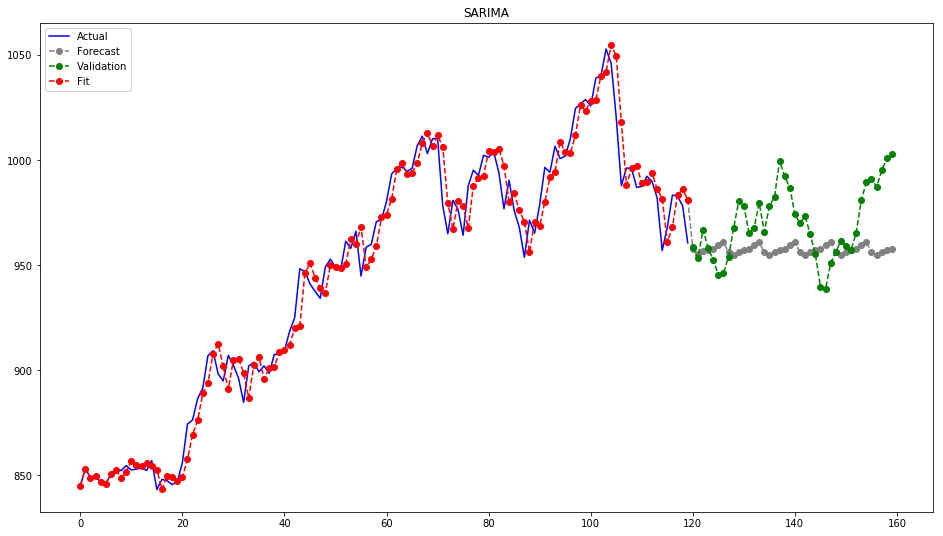

In [35]:
#xt_cls = list(df['Date'].map(lambda x: str(x)[:10]))
pred_period = 40
x = [i for i in range(len(data)-1, len(data) + pred_period)]
fcast = [clf.fittedvalues[-1]]
for i in clf.forecast(pred_period):
    fcast.append(i)
#s, d = gpf.forecastOutliers(X, metric, clf_sar, 'SARIMAX')
plt.figure(figsize=(16,9))
plt.plot(data, 'blue', label = 'Actual')
fit_y = [data[i] if i<7 else clf.fittedvalues[i] 
         for i in range(0, len(data))]
plt.plot(x, fcast, 'o--', c='grey', label ='Forecast')
plt.plot(x[1:], test[:pred_period], 'o--', c='green', label ='Validation')
plt.plot(fit_y, 'o--', color='red', label = 'Fit')
#plt.xticks(df.index[-120:], xt_cls[-120:], rotation = 90)
# plt.gca().set_yticklabels(['{:.3f}%'.format(x*100) 
#                        for x in plt.gca().get_yticks()])
plt.legend(loc=2)
plt.title('SARIMA')

plt.show()